### Sirada Thoungvitayasutee 301292632
### Assignment 4

In [1]:
#import
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from scipy.ndimage import rotate

### 1. Retrieve and load the Olivetti faces dataset.

In [2]:
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X = data.data
y = data.target

In [3]:
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


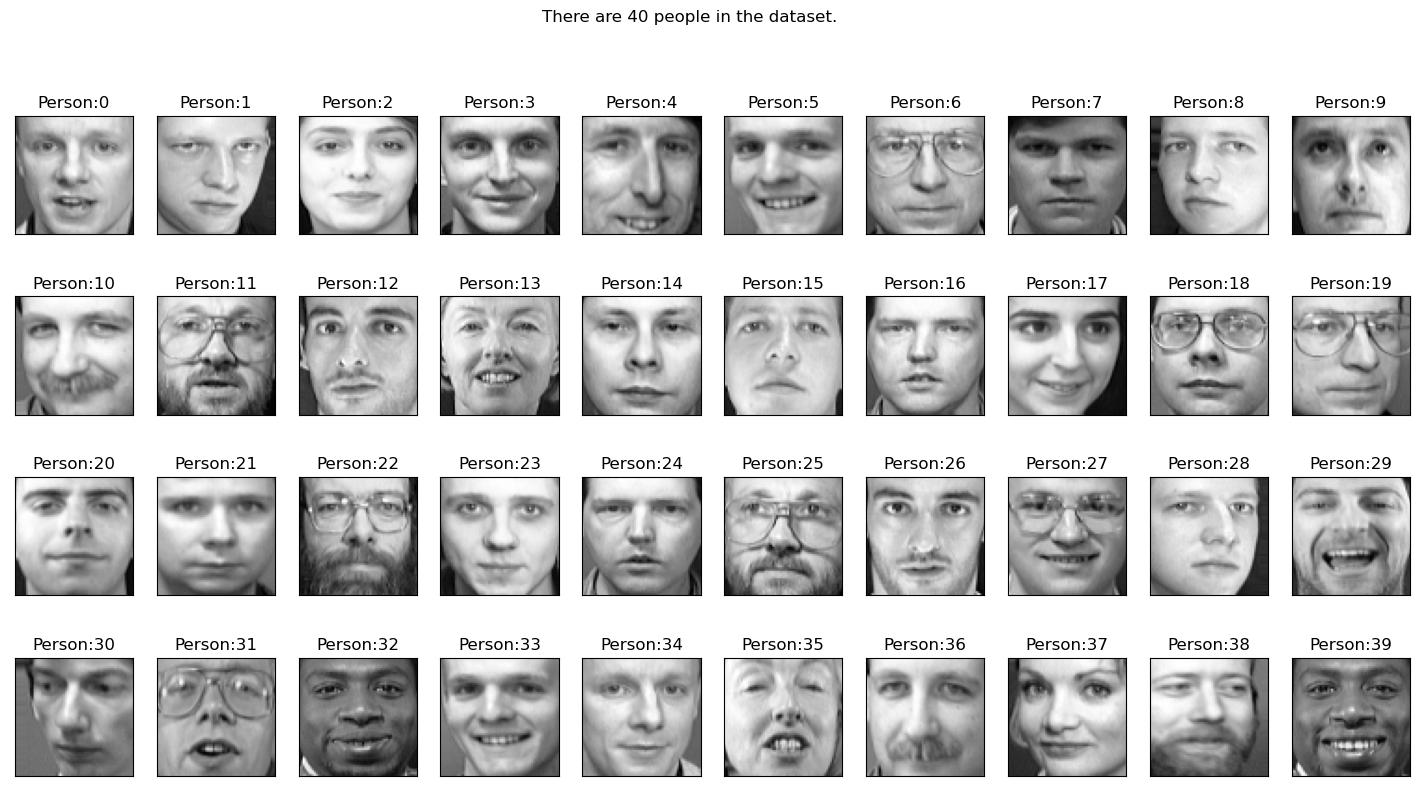

In [4]:
#print sample of the faces
def show_sample_faces(images, unique_ids):
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18,9))
    axarr = axarr.flatten()
    
    for unique_id in unique_ids:
        image_index = unique_id*10
        #reshape from flattened to 64x64
        image_reshaped = images[image_index].reshape(64,64) 
        axarr[unique_id].imshow(image_reshaped, cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title('Person:{}'.format(unique_id))
    plt.suptitle('There are 40 people in the dataset.')

show_sample_faces(X, np.unique(y))

### 2. Split the dataset into training, validation, and test sets using stratified sampling to ensure that each set contains the same number of images per person.

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, temp_index = next(split.split(X,y))
X_train, X_temp = X[train_index], X[temp_index]
y_train, y_temp = y[train_index], y[temp_index]

#split testing and val
split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(split_val_test.split(X_temp, y_temp))
X_val, X_test = X_temp[val_index], X_temp[test_index]
y_val, y_test = y_temp[val_index], y_temp[test_index]
#output
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Val set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (320, 4096), (320,)
Val set: (40, 4096), (40,)
Test set: (40, 4096), (40,)


<AxesSubplot:title={'center':'Training Set: Number of Samples Per Class'}, xlabel='subject ids'>

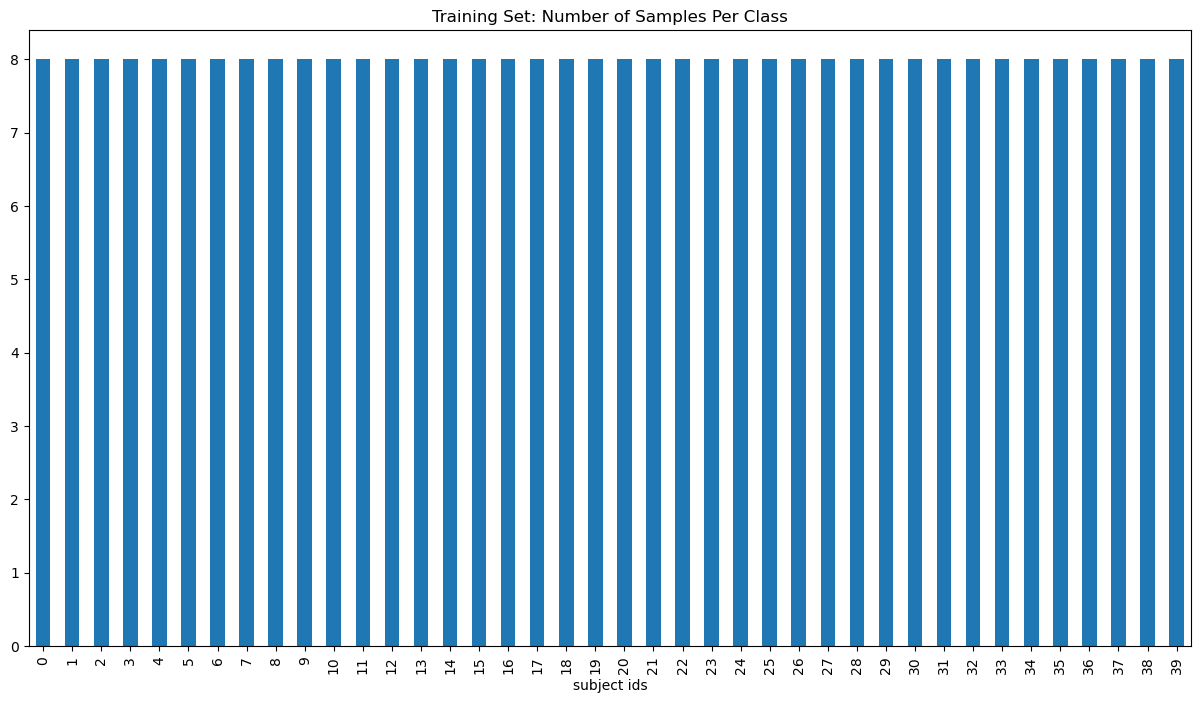

In [6]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Training Set: Number of Samples Per Class')

<AxesSubplot:title={'center':'Validation Set: Number of Samples Per Class'}, xlabel='subject ids'>

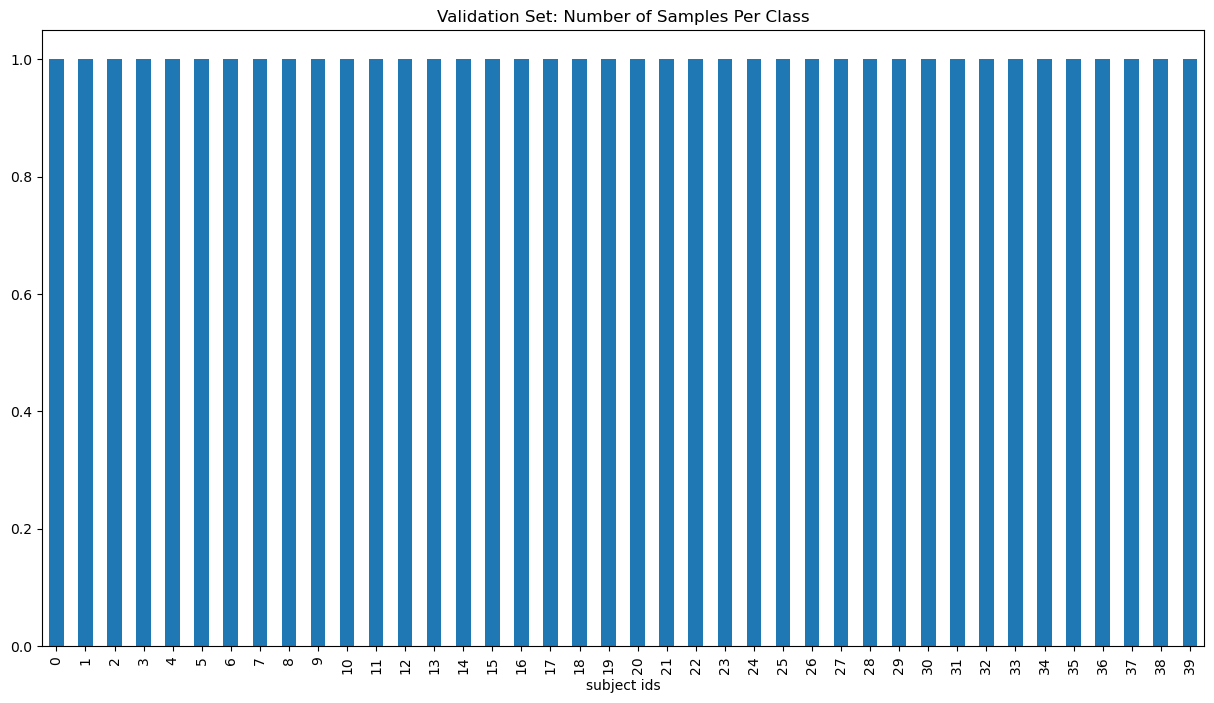

In [7]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_val
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Validation Set: Number of Samples Per Class')

<AxesSubplot:title={'center':'Testing Set: Number of Samples Per Class'}, xlabel='subject ids'>

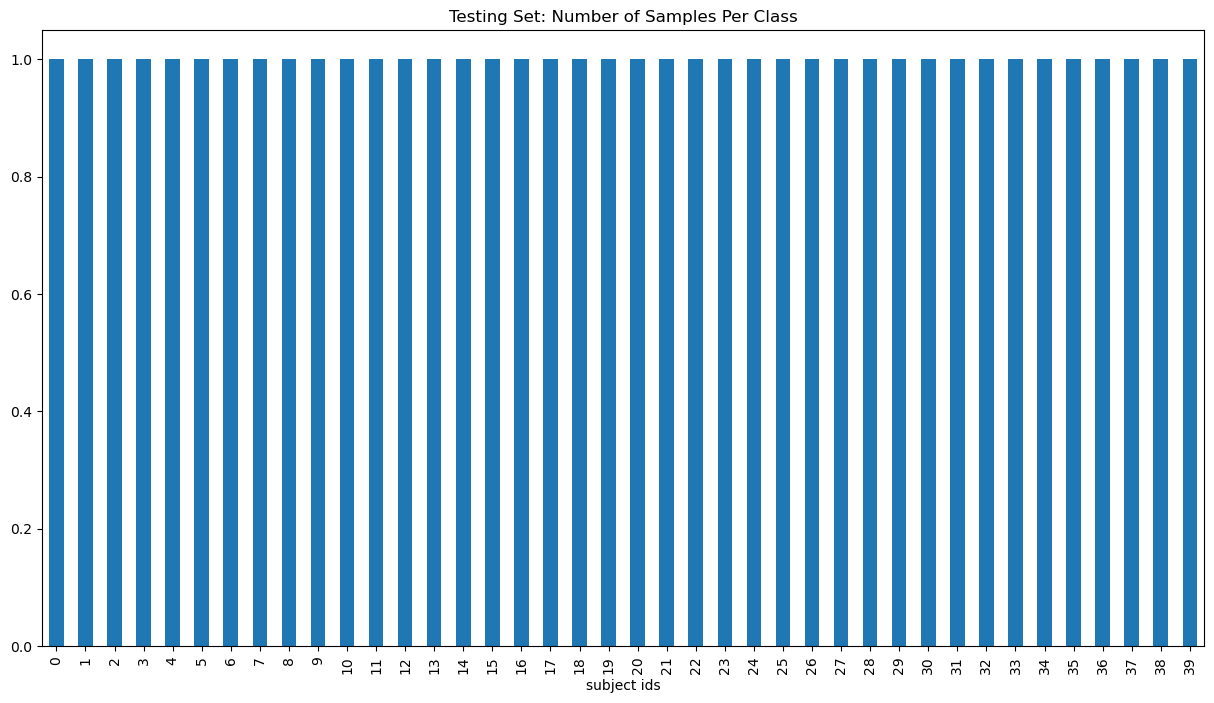

In [8]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_test
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Testing Set: Number of Samples Per Class')

### 3. Apply PCA on the training data, preserving 99% of the variance, to reduce the dataset’s dimensionality. 

In [9]:
#preserving 99%
# keep enough principal components so that 99% fo the data's variance is retained
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

print(X_train_pca.shape)
print(X_train.shape)

(320, 221)
(320, 4096)


### 4. Determine the most suitable covariance type for the dataset.

In [26]:
#try different covariance type to find the most suitable type
covariance_types = ['full', 'tied', 'diag', 'spherical']

aic_scores_type = []
bic_scores_type = []

n_components = 3
n_init = 10
#calculate aic and bic score
for cov_type in covariance_types:
    #fit the GMM model
    gmm = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov_type, random_state=42)
    gmm.fit(X_train_pca)
        
    #append aic and bic score
    aic = gmm.aic(X_train_pca)
    bic = gmm.bic(X_train_pca)
        
    aic_scores_type.append((cov_type, aic))
    bic_scores_type.append((cov_type, bic))
    print(f'Covariance type: {cov_type}, AIC: {aic}, BIC: {bic}')

best_aic = min(aic_scores_type, key=lambda x: x[1])
best_bic = min(bic_scores_type, key=lambda x: x[1])

#the lower the score, the better it fits the model
print(f'\nBest AIC:\nCovariance Type: {best_aic[0]}, Score: {best_aic[1]}')
print(f'\nBest BIC:\nCovariance Type: {best_bic[0]}, Score: {best_bic[1]}')

Covariance type: full, AIC: -242606.9732787325, BIC: 37221.00722692144
Covariance type: tied, AIC: 65805.35670586486, BIC: 160751.97251588473
Covariance type: diag, AIC: 15772.501870631608, BIC: 20776.832153045736
Covariance type: spherical, AIC: 109677.9611126541, BIC: 112195.19953784434

Best AIC:
Covariance Type: full, Score: -242606.9732787325

Best BIC:
Covariance Type: diag, Score: 20776.832153045736


### 5. Determine the minimum number of clusters that best represent the dataset using either AIC or BIC.

In [11]:
#range of cluster
n_components_range = range(1,20)
aic_scores_cluster =[]
bic_scores_cluster =[]
n_init = 10

best_covariance_aic = best_aic[0]
best_covariance_bic = best_bic[0]

print(f'Best covariance for AIC: {best_covariance_aic}')
print(f'Best covariance for BIC: {best_covariance_bic}')

for n_components in n_components_range:
    #fit the model
    gmm_aic = GaussianMixture(n_components=n_components, covariance_type=best_covariance_aic, n_init=10, random_state=42)
    gmm_aic.fit(X_train_pca)
    gmm_bic = GaussianMixture(n_components=n_components, covariance_type=best_covariance_bic, n_init=10, random_state=42)
    gmm_bic.fit(X_train_pca)
    
    #store the score
    aic_score = gmm_aic.aic(X_train_pca)
    bic_score = gmm_bic.bic(X_train_pca)
    aic_scores_cluster.append(aic_score)
    bic_scores_cluster.append(bic_score)
    print(f'Cluster {n_components}, AIC: {aic_score}, BIC: {bic_score}')
    
#find the best number of clusters
optimal_n_clusters_aic = n_components_range[np.argmin(aic_scores_cluster)]
optimal_n_clusters_bic = n_components_range[np.argmin(bic_scores_cluster)]

print(f'Optimal number of clusters for AIC: {optimal_n_clusters_aic}')
print(f'Optimal number of clusters for BIC: {optimal_n_clusters_bic}')

Best covariance for AIC: full
Best covariance for BIC: diag
Cluster 1, AIC: 66047.89591806187, BIC: 19093.49381829032
Cluster 2, AIC: -70131.50402697822, BIC: 19065.18846590155
Cluster 3, AIC: -242606.9732787325, BIC: 20776.832153045736
Cluster 4, AIC: -302848.0031729519, BIC: 22243.39710764421
Cluster 5, AIC: -321936.73986743705, BIC: 24297.588152647528
Cluster 6, AIC: -309700.11444242403, BIC: 26801.915393708303
Cluster 7, AIC: -294791.5320421837, BIC: 28773.791127815617
Cluster 8, AIC: -268772.1764999463, BIC: 29570.25524511211
Cluster 9, AIC: -236848.7484343797, BIC: 32974.542806801444
Cluster 10, AIC: -199204.77643248485, BIC: 35028.95291397568
Cluster 11, AIC: -155126.9855415956, BIC: 36594.23808818319
Cluster 12, AIC: -122919.42838878708, BIC: 38357.93379263221
Cluster 13, AIC: -75372.11539127375, BIC: 40586.386163175775
Cluster 14, AIC: -31892.227505485993, BIC: 42194.38091820099
Cluster 15, AIC: 8004.082827595412, BIC: 44776.803234544466
Cluster 16, AIC: 53861.19787220098, BIC

### 6. Plot the results from steps 3 and 4.

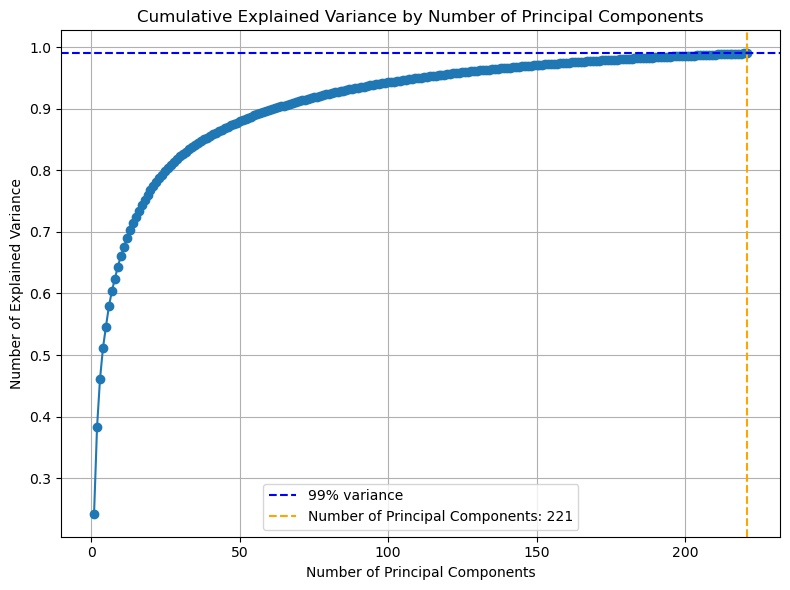

In [12]:
#plot PCA result
#calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_99 = np.argmax(cumulative_variance>=0.99) +1

plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Number of Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% variance')
plt.axvline(x=n_components_99, color='orange', linestyle='--', label=f'Number of Principal Components: {n_components_99}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

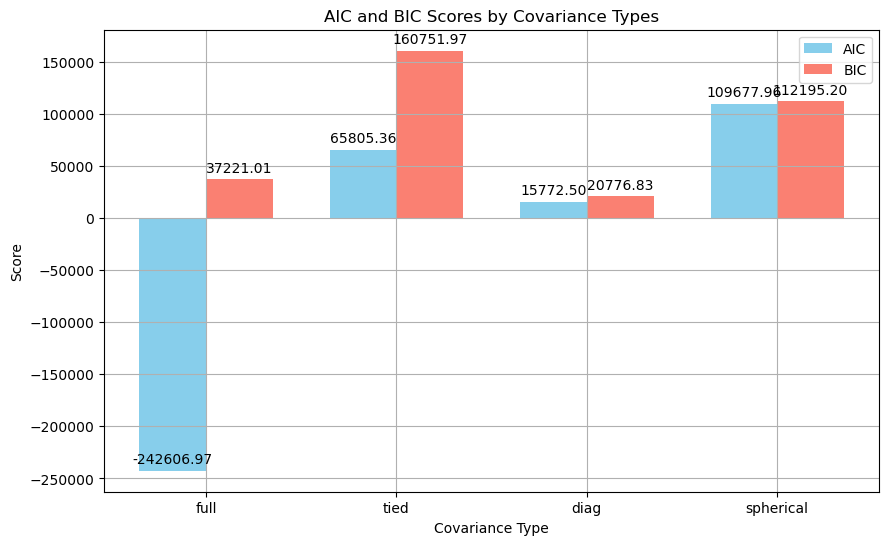

In [13]:
#different covariance type

x = np.arange(len(covariance_types))
width =0.35

fig, ax = plt.subplots(figsize=(10,6))

aic_score = [score[1] for score in aic_scores_type]
bic_score = [score[1] for score in bic_scores_type]

bar_aic = ax.bar(x- width/2, aic_score, width, label='AIC', color='skyblue')
bar_bic = ax.bar(x+ width/2, bic_score, width, label='BIC', color='salmon')

ax.set_xlabel('Covariance Type')
ax.set_ylabel('Score')
ax.set_title('AIC and BIC Scores by Covariance Types')
ax.set_xticks(x)
ax.set_xticklabels(covariance_types)
ax.legend()
ax.grid(True)

for bar in bar_aic+bar_bic:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
    xytext=(0,3),
    textcoords = 'offset points',
    ha='center', va='bottom')
plt.show()

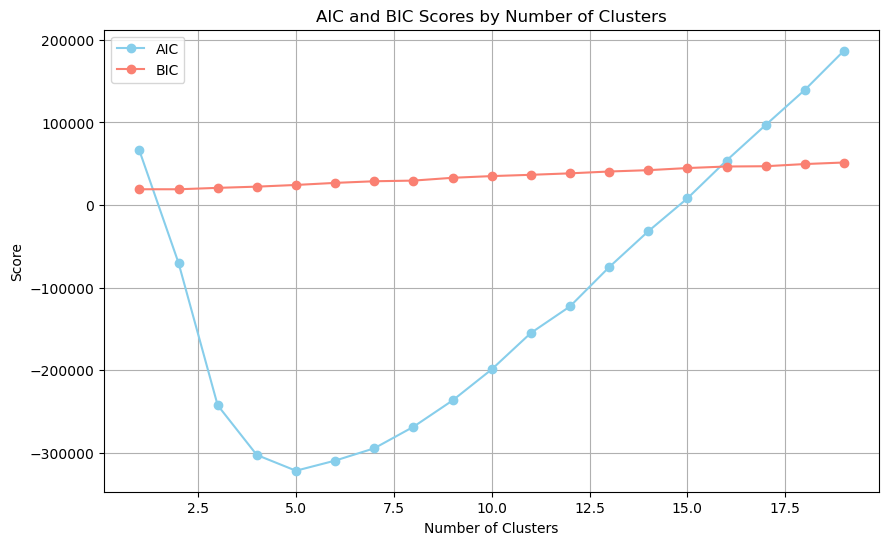

Optimal number of clusters for AIC: 5, Score: -321936.73986743705
Optimal number of clusters for BIC: 2, Score: 19065.18846590155


In [14]:
#plot optimal number of clusters
plt.figure(figsize=(10,6))
plt.plot(n_components_range, aic_scores_cluster, label='AIC', marker='o', color='skyblue')
plt.plot(n_components_range, bic_scores_cluster, label='BIC', marker='o', color='salmon')

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('AIC and BIC Scores by Number of Clusters')
plt.legend()
plt.grid(True)

plt.show()

print(f'Optimal number of clusters for AIC: {optimal_n_clusters_aic}, Score: {min(aic_scores_cluster)}')
print(f'Optimal number of clusters for BIC: {optimal_n_clusters_bic}, Score: {min(bic_scores_cluster)}')

### 7. Output the hard clustering assignments for each instance to identify which cluster each image belongs to.

In [15]:
#use predict from GMM to assign each instance with cluster with the highest probability
#fit the gmm
#use BIC for 2 clusters
print('BIC')
print(f'\nNumber of clusters: {optimal_n_clusters_bic}')
print(f'Covariance: {best_covariance_bic}')
print(f'n_init: {n_init}')

gmm = GaussianMixture(n_components=optimal_n_clusters_bic, covariance_type=best_covariance_bic,n_init=n_init, random_state=42)
gmm.fit(X_train_pca)

#predict cluster
hard_clusters = gmm.predict(X_train_pca)
print(f'\nHard Clusters: {hard_clusters}')
print(f'\nHard Clustering Shape: {hard_clusters.shape}')
print('')
cluster_counts = np.bincount(hard_clusters)

for cluster_id, count in enumerate(cluster_counts):
    print(f'Cluster: {cluster_id}, Count: {count}')

BIC

Number of clusters: 2
Covariance: diag
n_init: 10

Hard Clusters: [1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0
 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1
 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0
 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0
 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1]

Hard Clustering Shape: (320,)

Cluster: 0, Count: 187
Cluster: 1, Count: 133


### 8. Output the soft clustering probabilities for each instance to show the likelihood of each image belonging to each cluster.

In [16]:
#use predict proba
soft_clusters = gmm.predict_proba(X_train_pca)
print(f'\nSoft Clustering Shape: {soft_clusters.shape}')

print(f'\nSoft Clusters Probabilities for Each Instance\n{soft_clusters}')

#for first instance, cluster one has higher probability so more likely that it belongs to cluster 1


Soft Clustering Shape: (320, 2)

Soft Clusters Probabilities for Each Instance
[[7.68098700e-03 9.92319013e-01]
 [1.00000000e+00 2.55333293e-16]
 [1.00000000e+00 3.03491335e-11]
 [9.99999937e-01 6.34937324e-08]
 [5.52222654e-02 9.44777735e-01]
 [9.98455436e-01 1.54456380e-03]
 [9.99998736e-01 1.26370751e-06]
 [1.02998006e-03 9.98970020e-01]
 [9.99946274e-01 5.37263219e-05]
 [5.13664078e-06 9.99994863e-01]
 [3.87982770e-19 1.00000000e+00]
 [8.75438517e-14 1.00000000e+00]
 [1.00000000e+00 1.67209570e-12]
 [9.99999990e-01 9.66553594e-09]
 [4.22869966e-17 1.00000000e+00]
 [1.00000000e+00 3.70953785e-11]
 [4.34904983e-16 1.00000000e+00]
 [8.61299854e-01 1.38700146e-01]
 [1.69883888e-17 1.00000000e+00]
 [9.97809726e-01 2.19027368e-03]
 [5.05452151e-08 9.99999949e-01]
 [9.99999983e-01 1.70649529e-08]
 [3.35722636e-16 1.00000000e+00]
 [9.99999785e-01 2.14949837e-07]
 [9.99999805e-01 1.95143944e-07]
 [9.99602751e-01 3.97249466e-04]
 [9.99963112e-01 3.68881066e-05]
 [6.29112140e-25 1.00000000e+

### 9.Use the model to generate some new faces (using the sample() method) and visualize them (use the inverse_transform() method to transform the data back to its original space based on the PCA method used)

New point:
[[-5.39723498e+00  7.39983271e-01  8.32366181e-01 ...  1.61020318e-02
  -1.08112310e-01 -4.05919026e-03]
 [-2.73890744e+00 -5.74774507e+00  1.02410967e+00 ... -4.21876555e-02
   2.60537353e-01 -3.94434536e-02]
 [-2.33372609e+00 -1.70614961e+00 -1.84923706e+00 ... -1.55621237e-01
   2.60785586e-02  3.76188792e-02]
 [-6.38283022e-01 -2.07731635e-01  1.13210902e+00 ...  7.40348876e-03
   8.80124802e-02 -1.60815886e-01]
 [ 4.88149114e-01  6.68606359e-01  1.70526781e+00 ...  2.82057936e-02
   4.81709073e-02 -1.16623426e-01]]
New label:[0 0 0 1 1]


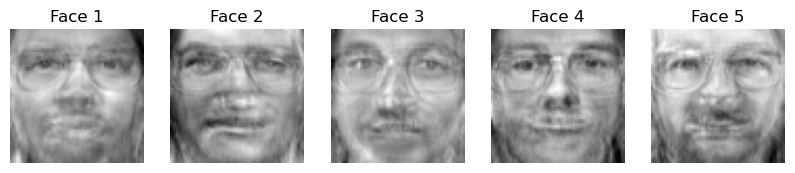

In [17]:
#generate new faces
num_sample = 5
#use sample() to generate new faces
X_new_pca, y_new_pca = gmm.sample(num_sample)

print(f'New point:\n{X_new_pca}')
print(f'New label:{y_new_pca}')


#use inverse_transform() to transform back to the original space 
X_new_inverse = pca.inverse_transform(X_new_pca)

#visualize the data
plt.figure(figsize=(10,5))
for i in range(num_sample):
    plt.subplot(1, num_sample, i+1)
    plt.imshow(X_new_inverse[i].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(f'Face {i+1}')
    
plt.show()

### 10. Modify some images (e.g., rotate, flip, darken).

In [18]:
#modify image
def modify_image(image, angle, factor):
    image = image.reshape(64,64)
    #rotate the image
    image = rotate(image, angle=angle, reshape=False)
    
    #flip the image
    image = np.fliplr(image)
    
    #darken the image and ensure that the pixel value is still within [0,1]
    image = np.clip(image - factor, 0, 1)
    
    return image

#modify some images in the training dataset
X_sample = X_train[:5]

#rotate by 180 degree
angle = 200

#darken factor
factor = 0.5

modified_images = [modify_image(image, angle, factor) for image in X_sample]

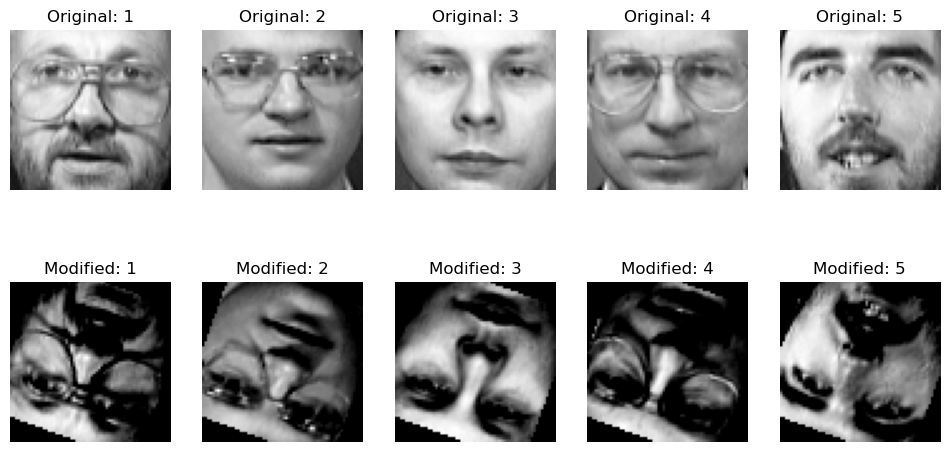

In [19]:
#plot the image
plt.figure(figsize=(12,6))

for i in range(len(X_sample)):
    #original image
    plt.subplot(2,num_sample, i+1)
    #reshape and visualiza original
    plt.imshow(X_sample[i].reshape(64,64), cmap='gray')
    plt.title(f'Original: {i+1}')
    plt.axis('off')
    
    #modified image
    plt.subplot(2, num_sample,i+1+5)
    #already reshaped
    plt.imshow(modified_images[i], cmap='gray')
    plt.title(f'Modified: {i+1}')
    plt.axis('off')
    
plt.show()

### 10. Determine if the model can detect the anomalies produced in step 10 by comparing the output of the score_samples() method for normal images and for anomalies.

In [20]:
#get sample
X_normal_sample = X_train[:5]

#reshape X_modify
X_anomalies_sample = np.array(modified_images).reshape(5,4096)

print(f'Normal Shape: {X_normal_sample.shape}')
print(f'Anomalies Shape: {X_anomalies_sample.shape}')

Normal Shape: (5, 4096)
Anomalies Shape: (5, 4096)


In [21]:
#apply pca before using the model
X_normal_pca = pca.transform(X_normal_sample)
X_anomalies_pca = pca.transform(X_anomalies_sample)

print(f'Normal PCA Shape: {X_normal_pca.shape}')
print(f'Anomalies PCA Shape: {X_normal_pca.shape}')

Normal PCA Shape: (5, 221)
Anomalies PCA Shape: (5, 221)


In [22]:
#use the gmm to compute the log-likelihood 
normal_scores = gmm.score_samples(X_normal_pca)
anomalies_scores = gmm.score_samples(X_anomalies_pca)

print(f'Normal Score:\n{normal_scores}')
print(f'\nAnomalies Score:\n{anomalies_scores}')

Normal Score:
[-27.85705488 -12.57045173   6.42636212 -19.81225931 -38.18324148]

Anomalies Score:
[-136.86699842 -133.60777174 -162.25263576 -121.37964848 -180.93401859]


Analysis: The scores for the normal images are higher than modified images. This shows that GMM has successfully detected the anomalies.

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html